Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images

In [1]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show, do_mask=False)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, num_epochs=10, n_train_stop=0, seed=1998, batch_size=6, num_workers=4, model_name='resnet50', do_scratch=False, lr=0.02, delta1=0.1, delta2=0.001, weight_decay=0.001, shuffle=True, verbose=True)

In [ ]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_bbox' / 'val'
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)

In [ ]:
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break

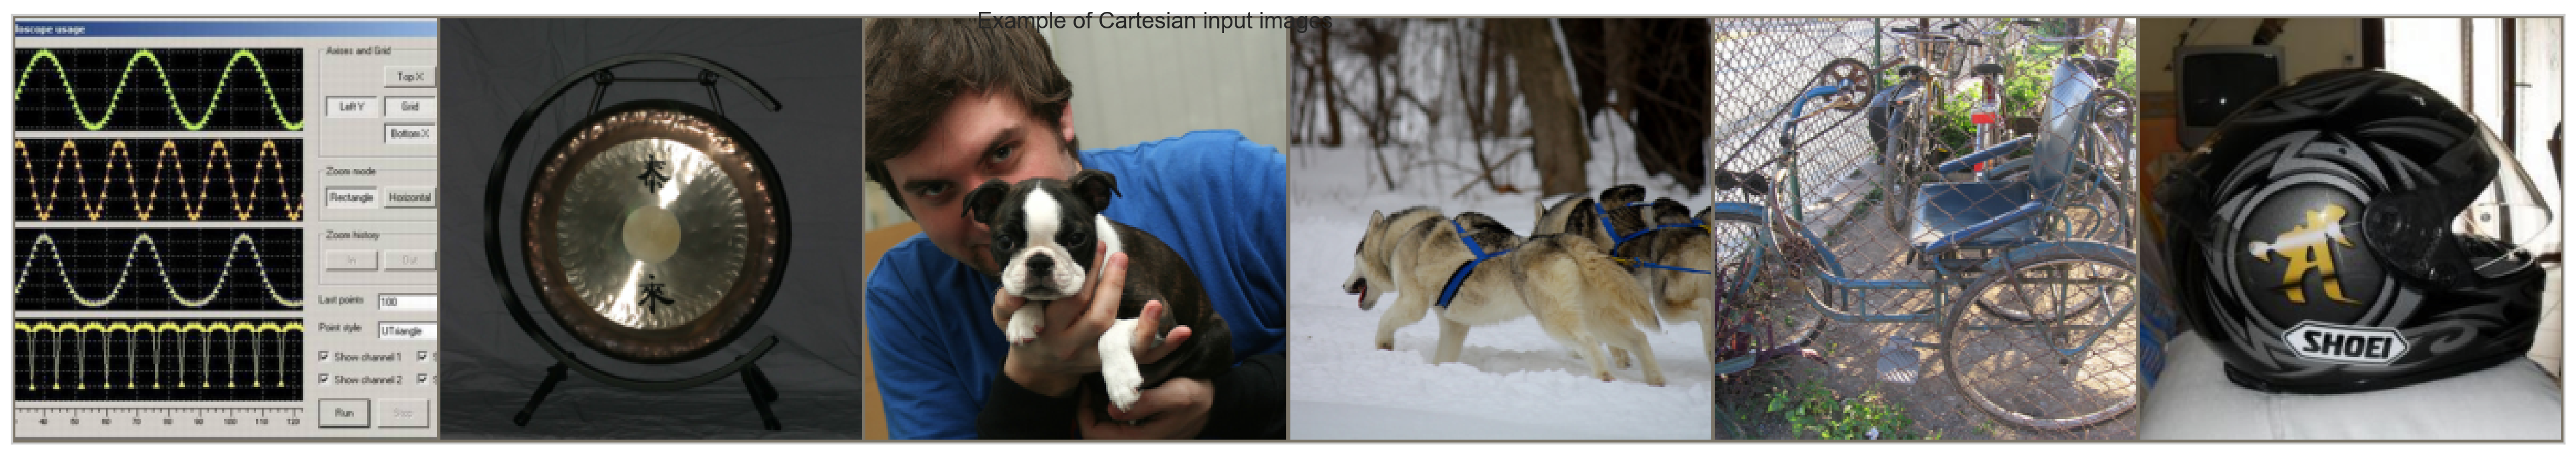

In [ ]:
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask

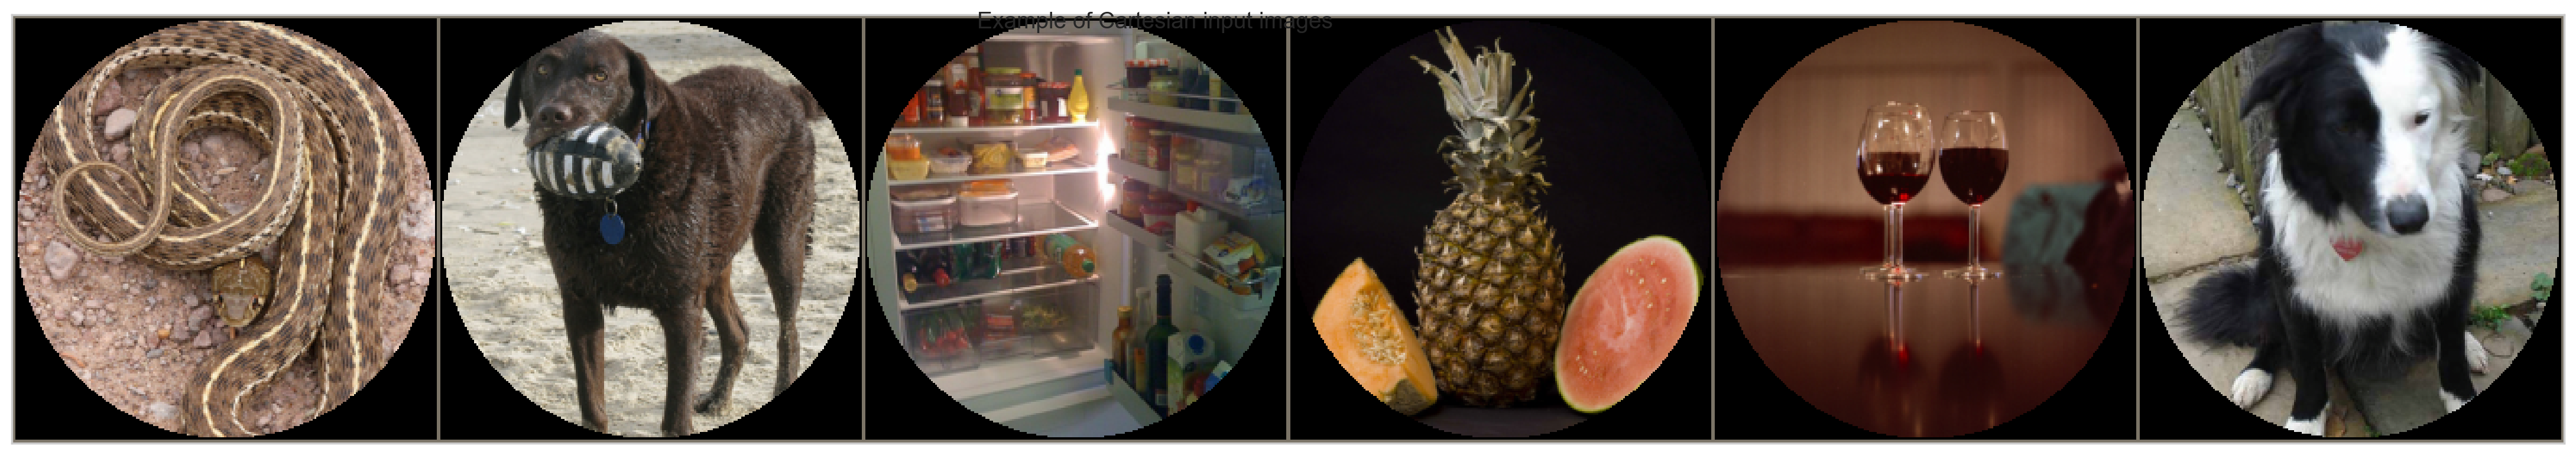

In [ ]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask and a rotation

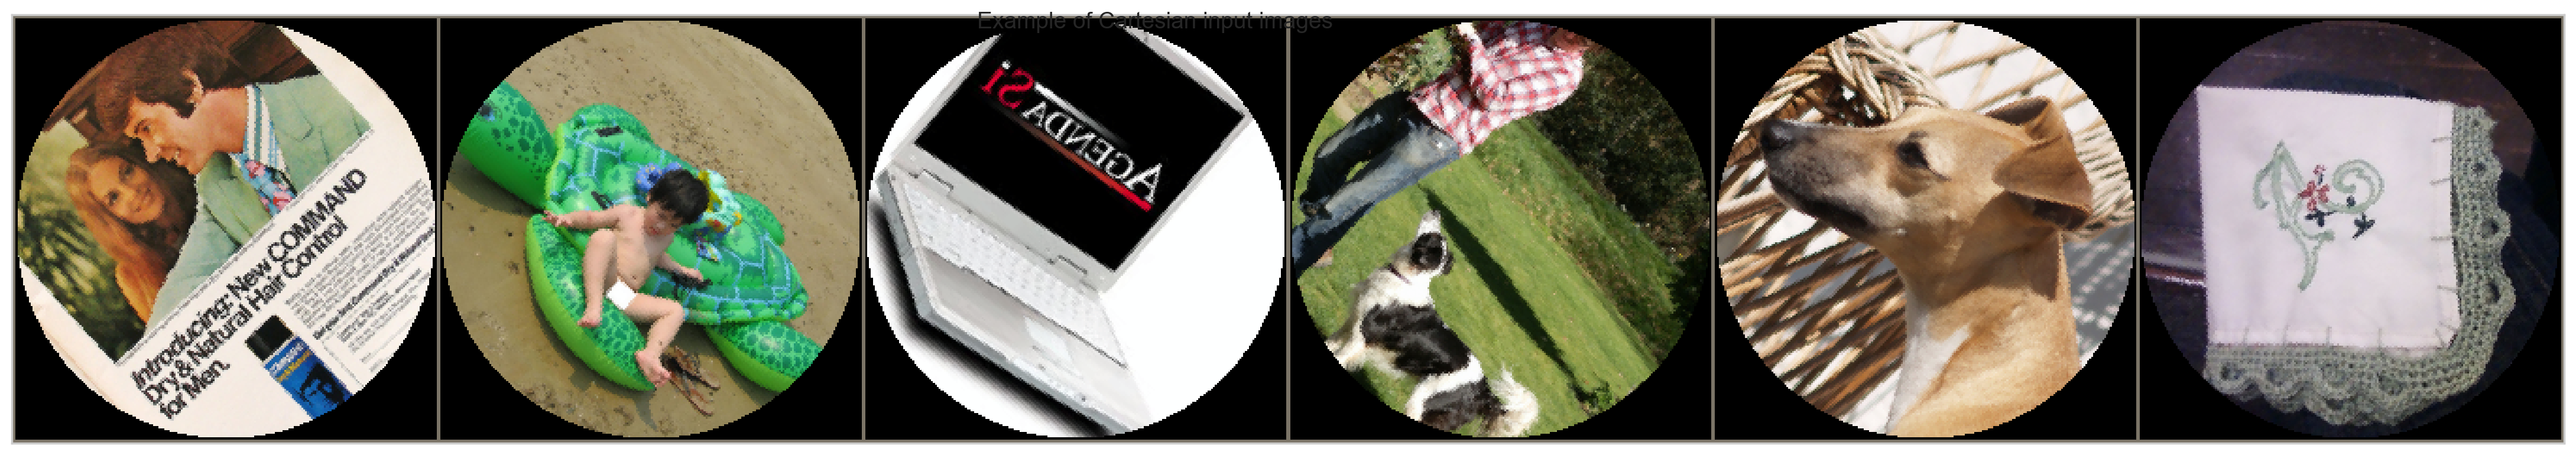

In [ ]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR, angle_min=40, angle_max=50)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# testing one image at different rotations

In [ ]:
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
model = fovea.load_model(args)
model.eval()
for images, true_labels in val_loader:
    print(f'Processing angle {i_angle+1}/{len(all_angles)-1} \t images {image_count}/{len(val_loader.dataset)}', end='\r')
    images = images.to(args.device)
    true_labels = true_labels.to(args.device)
images, true_labels


In [ ]:
all_angles = fovea.np.linspace(0, 180, 12) 


In [ ]:
images_angles = images
all_labels = []
for i_angle, angle in enumerate(all_angles[1:]):
    image_rot = fovea.TF.rotate(images, angle)
    images = fovea.torch.cat((images, image_rot))    
    all_labels.append(true_labels[0].item())

fig, ax = fovea.imshow(images, title='One image in rotation', fig_height=5)


In [ ]:
criterion = fovea.nn.CrossEntropyLoss(reduction='none')

with fovea.torch.no_grad():
    outputs = model(images)
    loss = criterion(outputs, true_labels).cpu().numpy()
    logits = outputs.cpu().numpy()

    _, predicted_labels = fovea.torch.max(outputs, dim=1)
    correct_predictions_in_batch = (predicted_labels == all_labels)
correct_predictions_in_batch



In [ ]:
idx_to_label = fovea.get_idx_to_label(args)

fig, ax = fovea.imshow(images_angles[[0, worst_angle], ...], title=f'A {idx_to_label[predicted_labels[0]]} becomes a {idx_to_label[predicted_labels[worst_angle]]} at a tilt of {all_angles[worst_angle]}°', fig_height=5)


# testing each network for different rotations

In [7]:
all_angles = fovea.np.linspace(-180, 180, 121)
all_angles = fovea.np.linspace(0, 180, 11)
all_angles = fovea.np.linspace(0, 180, 24)
all_angles = fovea.np.linspace(0, 180, 4) 
all_angles

array([  0.,  60., 120., 180.])

In [8]:
delta_angle = all_angles[1] - all_angles[0]
all_angles_min = all_angles - delta_angle / 2
all_angles_min, all_angles_min + delta_angle, delta_angle

(array([-30.,  30.,  90., 150.]),
 array([ 30.,  90., 150., 210.]),
 np.float64(60.0))

In [9]:
for model_name in  fovea.all_model_names:
    print(f'{model_name=}')



model_name='resnet18'
model_name='resnet50'
model_name='resnet101'


In [10]:
for angles_min, angles_max in zip(all_angles_min, all_angles_min + delta_angle):
    print(f'{fovea.np.mod(angles_min,360)=:.3f}\t{fovea.np.mod(angles_max, 360)=:.3f}')

fovea.np.mod(angles_min,360)=330.000	fovea.np.mod(angles_max, 360)=30.000
fovea.np.mod(angles_min,360)=30.000	fovea.np.mod(angles_max, 360)=90.000
fovea.np.mod(angles_min,360)=90.000	fovea.np.mod(angles_max, 360)=150.000
fovea.np.mod(angles_min,360)=150.000	fovea.np.mod(angles_max, 360)=210.000


In [11]:
npz_filename = args.data_cache / f'16_all_{args.model_name}.npz'

# %rm {npz_filename}  # FORCING RECOMPUTE

if npz_filename.exists():
    with fovea.np.load(npz_filename) as data:
        # --- 3. Access the arrays inside the 'with' block ---
        # It's good practice to convert to tensors (or whatever final format you need)
        # right away, so you don't need to keep the file open.
        attack_angle = data['attack_angle']
        attack_success = data['attack_success']
        all_results = data['results']
else:
    VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
    model = fovea.load_model(args)
    model.eval()

    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
    criterion = fovea.nn.CrossEntropyLoss(reduction='none')
    dataset_len = len(val_loader.dataset)
    all_results = fovea.np.empty((len(all_angles), dataset_len)) 
    all_logits = fovea.np.empty((len(all_angles), dataset_len, model.fc.out_features)) 
    all_losses = fovea.np.empty((len(all_angles), dataset_len)) 
    all_labels = []
    for i_angle, (angle_min, angle_max) in enumerate(zip(all_angles_min, all_angles_min + delta_angle)):
        args = fovea.Params(shuffle=False, do_mask=True)
        val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR, angle_min=angle_min, angle_max=angle_max)

        correct_predictions = 0
        total_predictions = 0

        image_count = 0
        for images, true_labels in val_loader:
            print(f'Processing angle {i_angle+1}/{len(all_angles)} \t images {image_count}/{len(val_loader.dataset)}', end='\r')
            images = images.to(args.device)
            true_labels = true_labels.to(args.device)

            # Get predictions (no need for gradients)
            with torch.no_grad():
                if i_angle==0: all_labels.extend([l.item() for l in true_labels])
                outputs = model(images)
                all_logits[i_angle, image_count:(image_count + images.size(0)), :] = outputs.cpu().numpy()
                _, predicted_labels = torch.max(outputs, dim=1)
                correct_predictions_in_batch = (predicted_labels == true_labels)
                all_results[i_angle, image_count:image_count + images.size(0)] = correct_predictions_in_batch.cpu().numpy()
                loss = criterion(outputs, true_labels)
                all_losses[i_angle, image_count:(image_count + images.size(0))] = loss.cpu().numpy()
            image_count += images.size(0)

    attack_angle = all_losses.argmax(axis=0)
    attack_idx = all_logits[attack_angle, fovea.np.arange(dataset_len), :].argmax(axis=1)
    attack_success = (attack_idx == all_labels)


    fovea.np.savez(npz_filename, 
            attack_angle=attack_angle,
            attack_success=attack_success,
            results=all_results)



# analysis: average accuracy for different rotations

In [12]:
all_results.shape

(4, 50000)

In [13]:
all_results.mean(axis=1)

array([0.67712, 0.62928, 0.56876, 0.51144])

(0.0, 1.05)

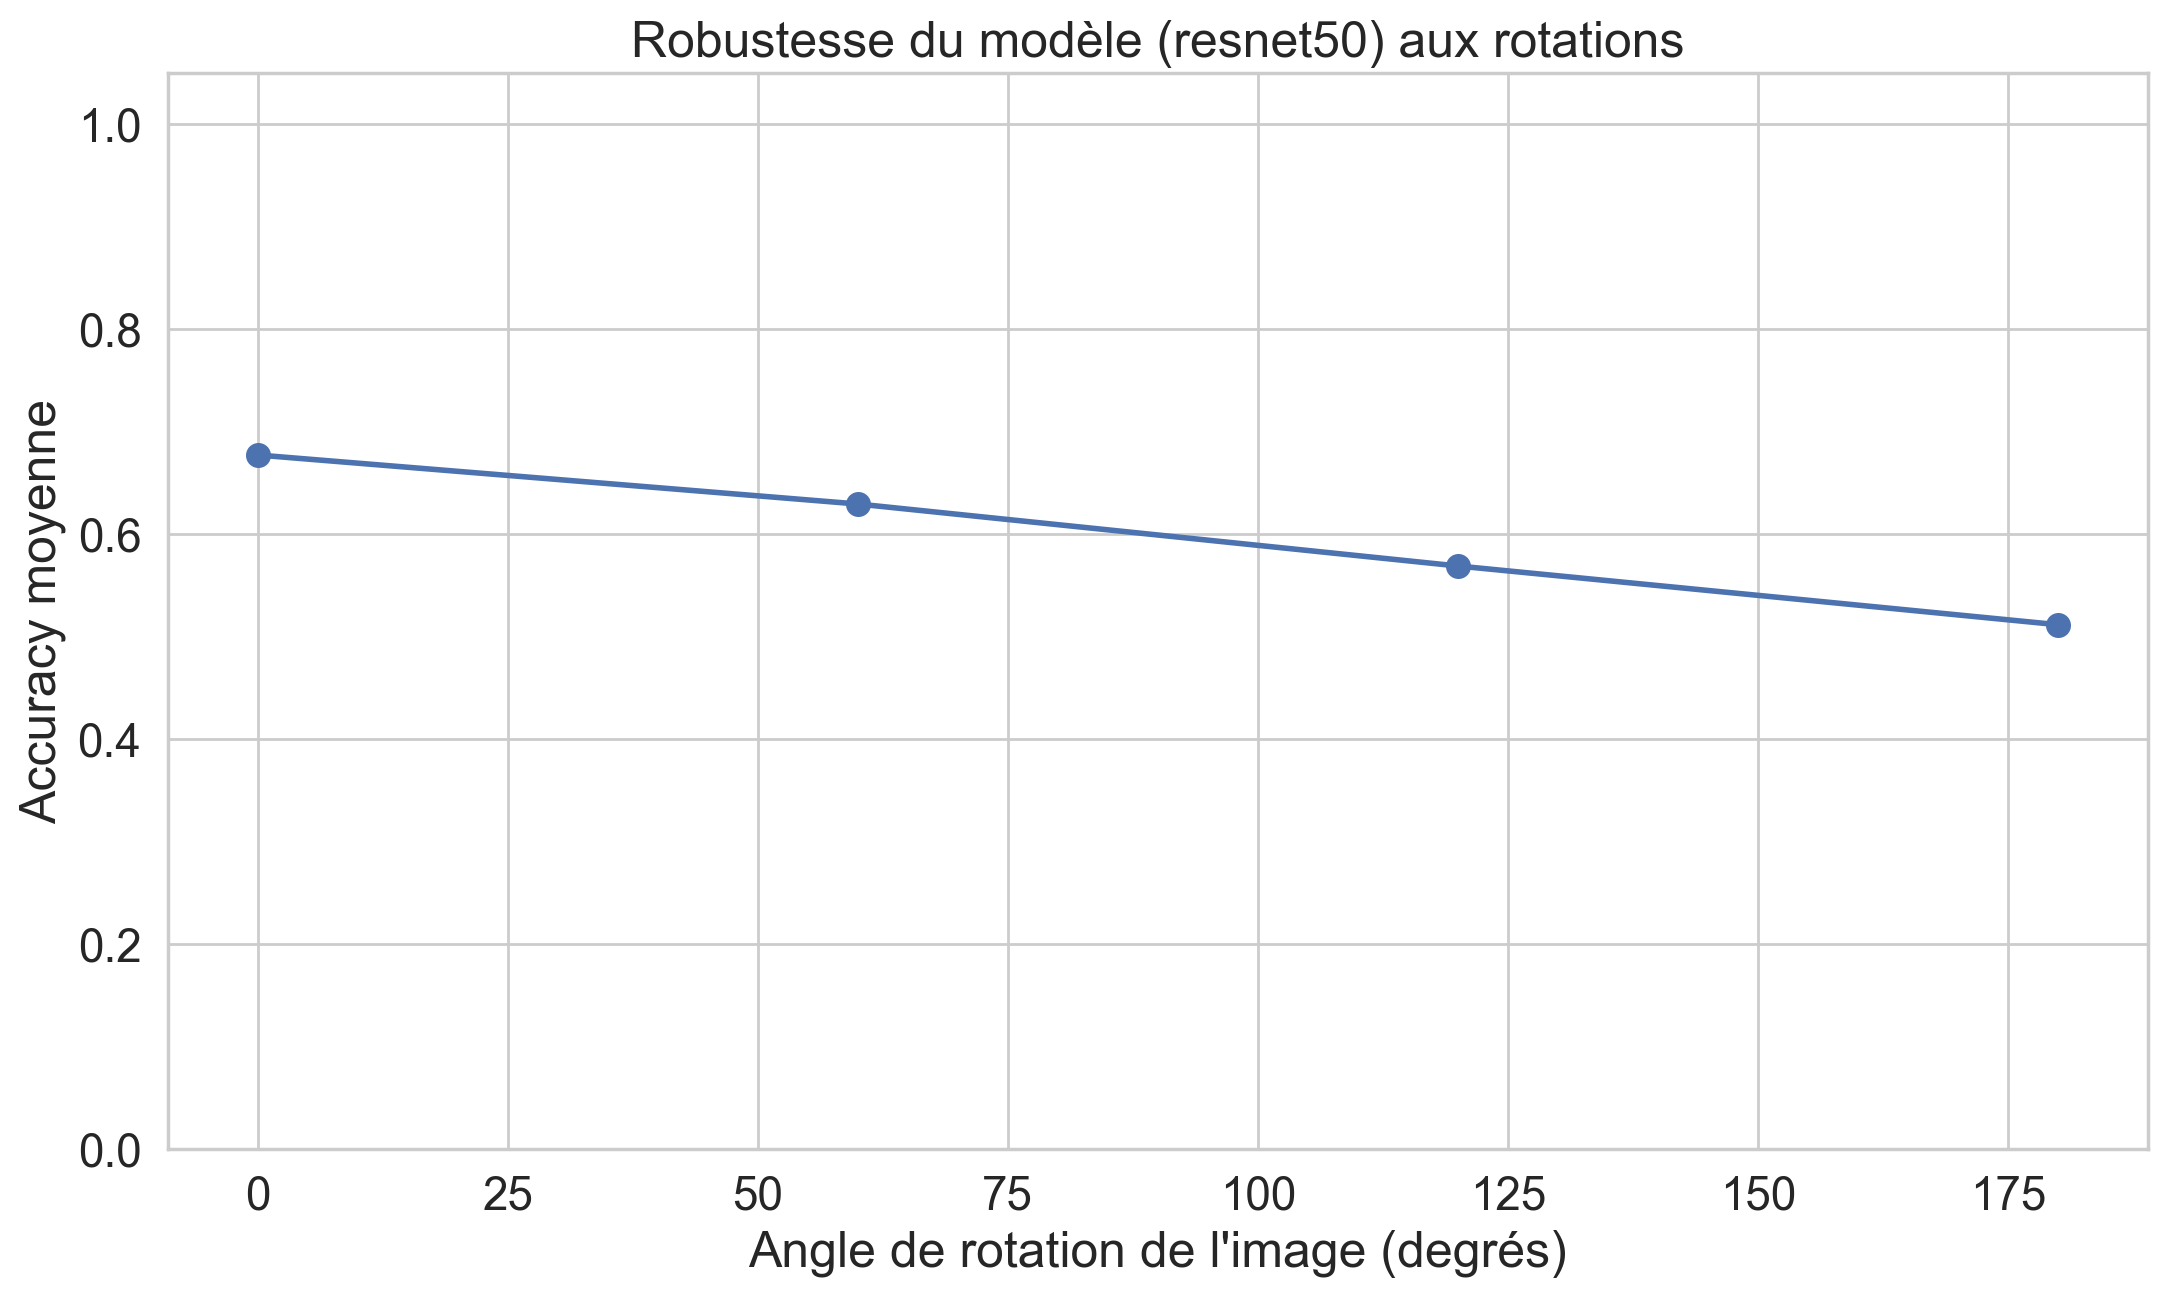

In [14]:
# `all_results` est un tableau de booléens (True/False pour correct/incorrect)
# Pour calculer la précision, on calcule la moyenne (True=1, False=0) sur l'axe des images (axe=1)
mean_accuracy_per_angle = all_results.mean(axis=1)

# --- Création du Plot ---
fig, ax = fovea.plt.subplots()

# Tracer l'accuracy moyenne en fonction de l'angle de référence
ax.plot(all_angles, mean_accuracy_per_angle, marker='o', linestyle='-', lw=2, markersize=8)

# --- Finalisation du Graphique ---
ax.set_xlabel("Angle de rotation de l'image (degrés)")
ax.set_ylabel("Accuracy moyenne")
ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations")
ax.set_ylim(0, 1.05) # S'assurer que l'axe des y est bien entre 0 et 1

# On peut ajouter une ligne horizontale pour la performance de base (angle=0)
# if 0 in all_angles[:-1]:
#     base_accuracy = mean_accuracy_per_angle[all_angles == 0][0]
#     plt.axhline(y=base_accuracy, color='r', linestyle='--', label=f'Performance de base (angle=0): {base_accuracy:.2f}')
#     plt.legend()


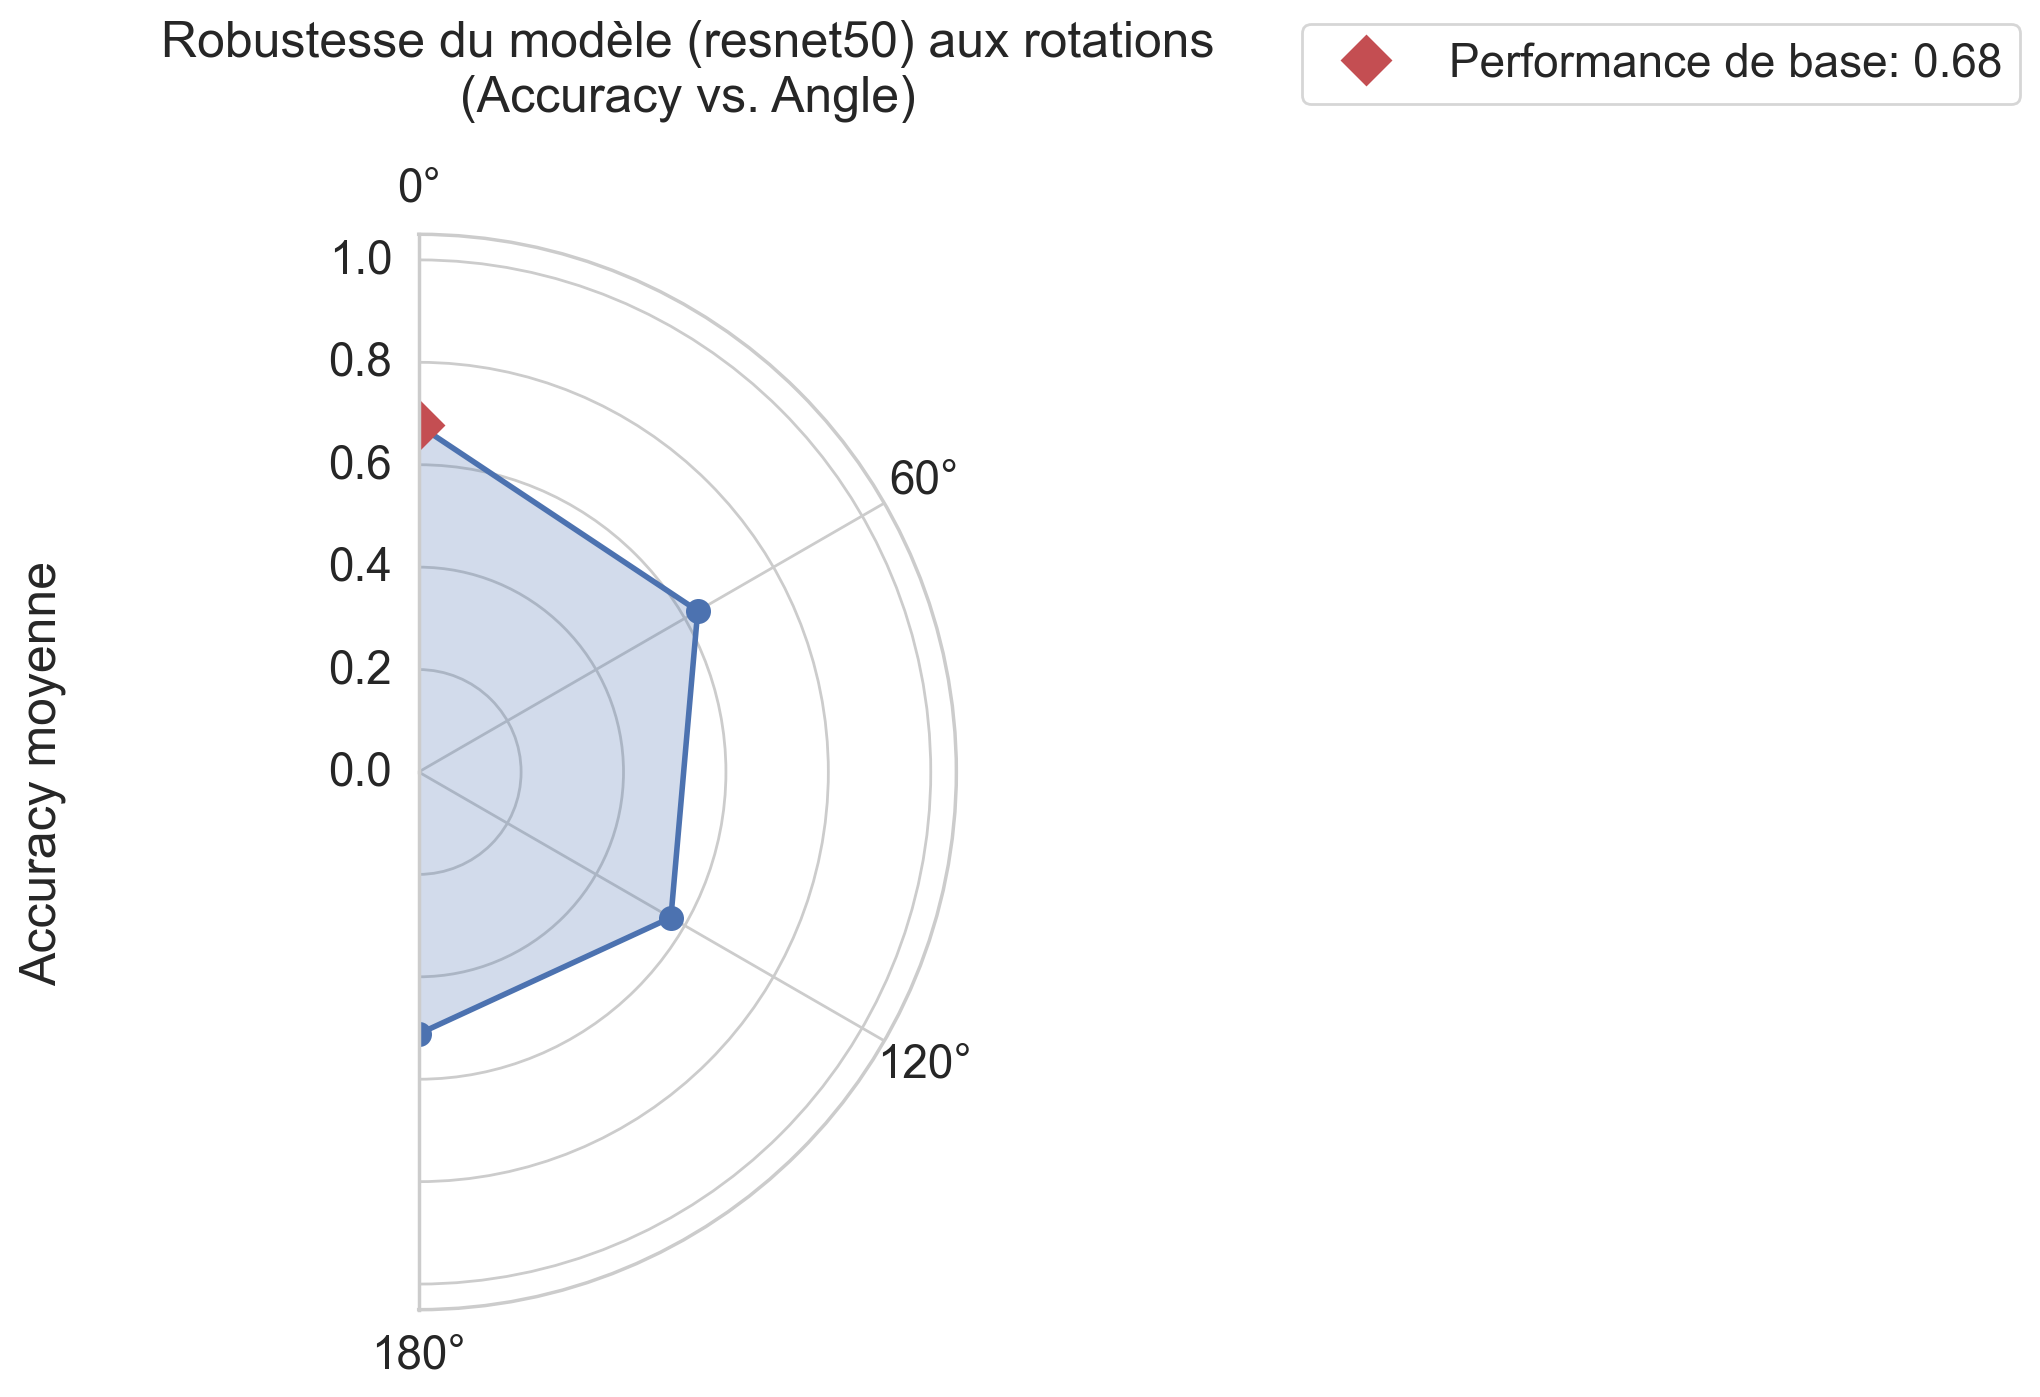

In [15]:
# --- Création du Polar Plot ---

# 1. Créer la figure et l'axe en projection polaire
fig = fovea.plt.figure()
ax = fig.add_subplot(111, polar=True)

# 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
angles_rad = fovea.np.deg2rad(all_angles)

# 3. Tracer les données en coordonnées polaires
ax.plot(angles_rad, mean_accuracy_per_angle, marker='o', linestyle='-', lw=2, markersize=8, color='b')

# 4. Remplir la zone sous la courbe pour un meilleur effet visuel
ax.fill(angles_rad, mean_accuracy_per_angle, alpha=0.25, color='b')

# --- Finalisation du Graphique Polaire ---
# Définir la direction du zéro (haut) et le sens horaire/anti-horaire
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

# Définir les étiquettes des angles sur le cercle
# S'assurer que les étiquettes sont alignées
ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles])

# Définir les limites et les étiquettes de l'axe radial (l'accuracy)
ax.set_xlim(0, fovea.np.pi)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

# Ajouter un titre
ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)

# Ajouter la ligne de performance de base (angle=0)
# Il faut trouver l'index de l'angle le plus proche de 0
zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
base_accuracy = mean_accuracy_per_angle[zero_angle_idx]
ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

In [16]:
all_angles

array([  0.,  60., 120., 180.])

In [17]:
all_angles_wrap = fovea.np.hstack((all_angles, fovea.np.mod(all_angles[1:]+180, 360)))
all_angles_wrap

array([  0.,  60., 120., 180., 240., 300.,   0.])

In [18]:
mean_accuracy_per_angle_wrap = fovea.np.hstack((mean_accuracy_per_angle, mean_accuracy_per_angle[:-1][::-1]))
mean_accuracy_per_angle_wrap

array([0.67712, 0.62928, 0.56876, 0.51144, 0.56876, 0.62928, 0.67712])

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_13185/1726389067.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))


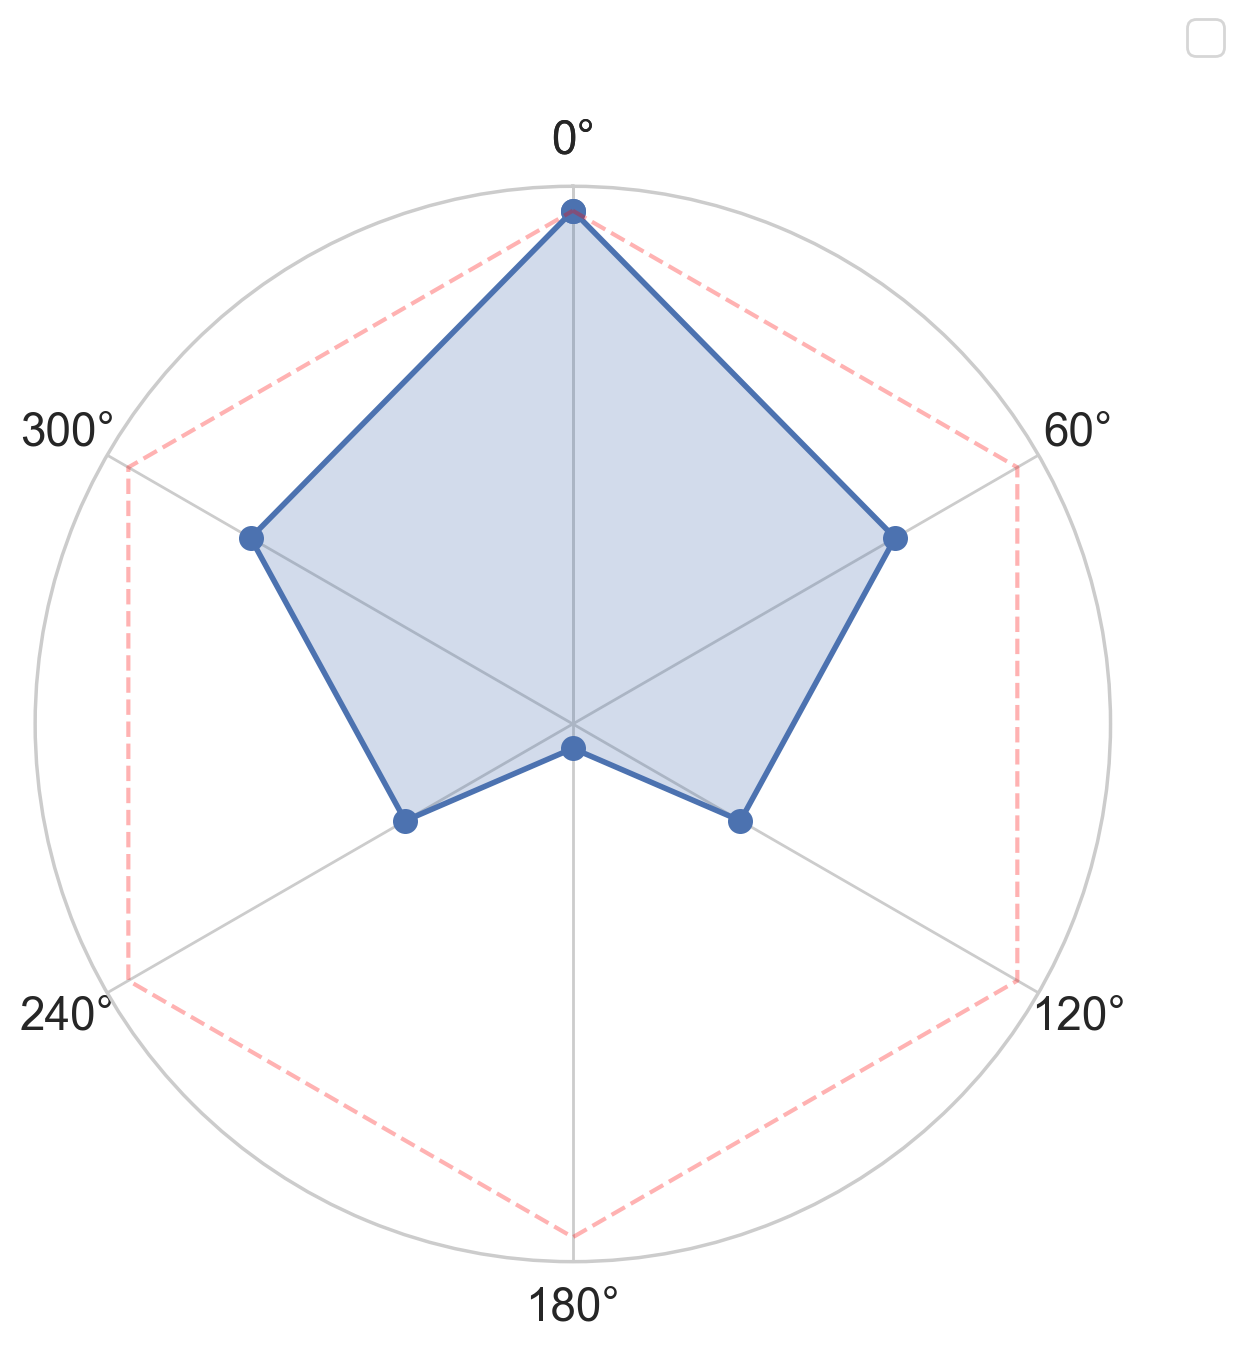

In [19]:
# --- Création du Polar Plot ---

# 1. Créer la figure et l'axe en projection polaire
fig = fovea.plt.figure()
ax = fig.add_subplot(111, polar=True)

# 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
angles_rad = fovea.np.deg2rad(all_angles_wrap)

# 3. Tracer les données en coordonnées polaires
ax.plot(angles_rad, mean_accuracy_per_angle_wrap, marker='o', linestyle='-', lw=2, markersize=8, color='b')

# 4. Remplir la zone sous la courbe pour un meilleur effet visuel
ax.fill(angles_rad, mean_accuracy_per_angle_wrap, alpha=0.25, color='b')

# --- Finalisation du Graphique Polaire ---
# Définir la direction du zéro (haut) et le sens horaire/anti-horaire
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

# Définir les étiquettes des angles sur le cercle
# S'assurer que les étiquettes sont alignées
ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles_wrap])

# Définir les limites et les étiquettes de l'axe radial (l'accuracy)
# ax.set_ylim(0, 1.05)
# ax.set_yscale('logit')
# ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

ax.set_yticks([])

# Ajouter un titre
# ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)

# Ajouter la ligne de performance de base (angle=0)
# Il faut trouver l'index de l'angle le plus proche de 0
zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
base_accuracy = mean_accuracy_per_angle[zero_angle_idx]
# ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
ax.plot(angles_rad, base_accuracy*fovea.np.ones_like(mean_accuracy_per_angle_wrap), '--', lw=1.5, alpha=.3, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

# analysis: average accuracy for different rotations

In [20]:
attack_angle.shape, attack_success.shape

((50000,), (50000,))

In [21]:
i_image = 42


In [28]:
fovea.np.unique(attack_angle)


array([0, 1, 2, 3])

In [29]:
all_angles

array([  0.,  60., 120., 180.])

In [27]:
fovea.sns.displot(x=all_angles, y=attack_angle)

ValueError: All arrays must be of the same length

In [25]:
attack_success

array([ True, False, False, ..., False, False, False], shape=(50000,))

In [26]:
attack_success.mean()

np.float64(0.41596)